# PPO Training Diagnostics - Decreasing Returns Analysis

This notebook analyzes why total rewards and average returns are consistently decreasing.

In [433]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Movement types (these do NOT contain dx/dy)
MOVE_ACTIONS = [
    "PURSUIT_FOOD",
    "RUN_FROM_PREDATOR",
    "TOWARD_PREDATOR"
]

FOOD_ACTIONS = ["REPRODUCE", "ACTIVATE_SPECIAL", "IDLE_FOOD"]

ACTION_COUNT = len(MOVE_ACTIONS) * len(FOOD_ACTIONS)


def decode_action(idx):
    move_idx = idx // len(FOOD_ACTIONS)
    food_idx = idx % len(FOOD_ACTIONS)
    return MOVE_ACTIONS[move_idx], FOOD_ACTIONS[food_idx]
import os
import json
import re
import pandas as pd

# Folder containing log files
LOG_DIR = "./training_logs_ppo"   # change this if needed

# Regex to match your filenames
pattern = re.compile(r"episode_(\d+)_(\d+)(\.json)?$")

rows = []

for fname in os.listdir(LOG_DIR):
    match = pattern.match(fname)
    if not match:
        continue

    episode_num = int(match.group(1))
    timestamp = int(match.group(2))

    full_path = os.path.join(LOG_DIR, fname)

    with open(full_path, "r") as f:
        data = json.load(f)
    metrics = data['metrics']
    print(metrics)
    stats = data["stats"]
    recent_avg_return=data['recent_avg_return']
    food_counts=stats['food_counts']
    # Extract meta

    row = {
        "filename": fname,
        "episode": data["episode"],
        "timestamp": data["timestamp"],
        "total_messages": stats["total_messages"],
        "total_updates": stats["total_updates"],
        "total_reward": stats["total_reward"],
        "food_counts": food_counts,
        "recent_avg_return": recent_avg_return,
        "policy_loss": metrics.get("policy_loss"),
        "value_loss": metrics.get("value_loss"),
        "entropy": metrics.get("entropy"),
        "approx_kl": metrics.get("approx_kl"),
        "mean_ratio": metrics.get("mean_ratio"),
        "percent_clipped": metrics.get("percent_clipped"),
        "explained_variance": metrics.get("explained_variance"),
        "adv_mean": metrics.get("adv_mean"),
        "adv_std": metrics.get("adv_std"),
        "episode_length": metrics.get("episode_length"),
        "logp_move_mean"    : metrics.get("logp_move_mean"),
        "logp_move": metrics.get("logp_move"),
    

    }

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

print(df.head())
print("\nTotal logs parsed:", len(df))


{'policy_loss': -0.0028758312885959945, 'value_loss': 0.12945989581445852, 'entropy': 18.240115642547607, 'approx_kl': -0.004393215601642926, 'mean_ratio': 1.0113125691811244, 'percent_clipped': 11.735733598470688, 'adv_mean': 4.384709484384075e-08, 'adv_std': 1.0, 'reward_mean': -0.018189655172413794, 'reward_std': 0.040508069394726655, 'return_mean': -1.3211215734481812, 'value_mean': -1.659593939781189}
{'policy_loss': 0.0008420445956289768, 'value_loss': 0.11548548626403014, 'entropy': 18.223559538523357, 'approx_kl': 0.037904967864354454, 'mean_ratio': 1.0023731937011082, 'percent_clipped': 25.026041517655056, 'adv_mean': 4.238552619995062e-08, 'adv_std': 0.9999998807907104, 'reward_mean': -0.0175, 'reward_std': 0.1351542328847553, 'return_mean': -1.2675200700759888, 'value_mean': -1.5739281177520752}
{'policy_loss': -0.0019216202199459076, 'value_loss': 0.1187278623401653, 'entropy': 18.208016991615295, 'approx_kl': 0.025749359279870987, 'mean_ratio': 0.9917592145502567, 'percent

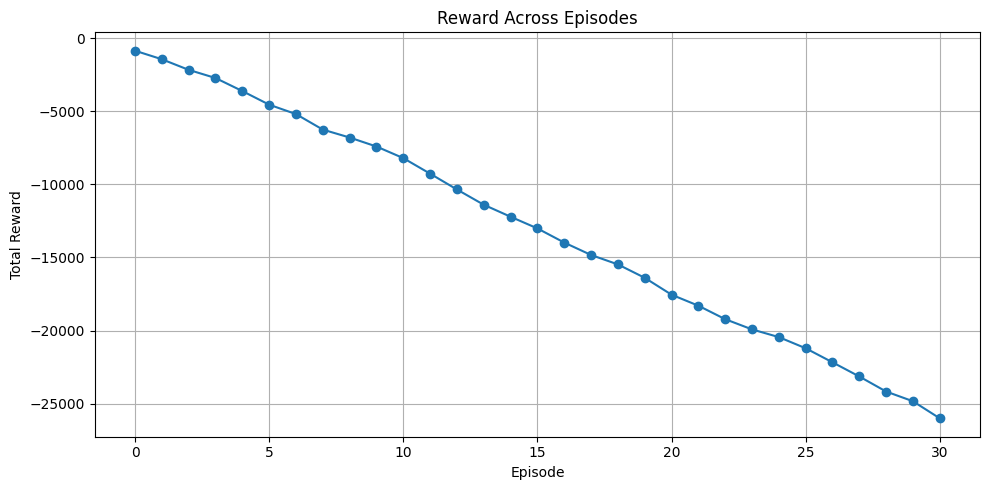

In [434]:
import matplotlib.pyplot as plt

# df must contain: df["episode"], df["total_reward"]
df_sorted = df.sort_values("episode")

plt.figure(figsize=(10, 5))
plt.plot(df_sorted["episode"], df_sorted["total_reward"], marker="o")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Across Episodes")
plt.grid(True)
plt.tight_layout()
plt.show()


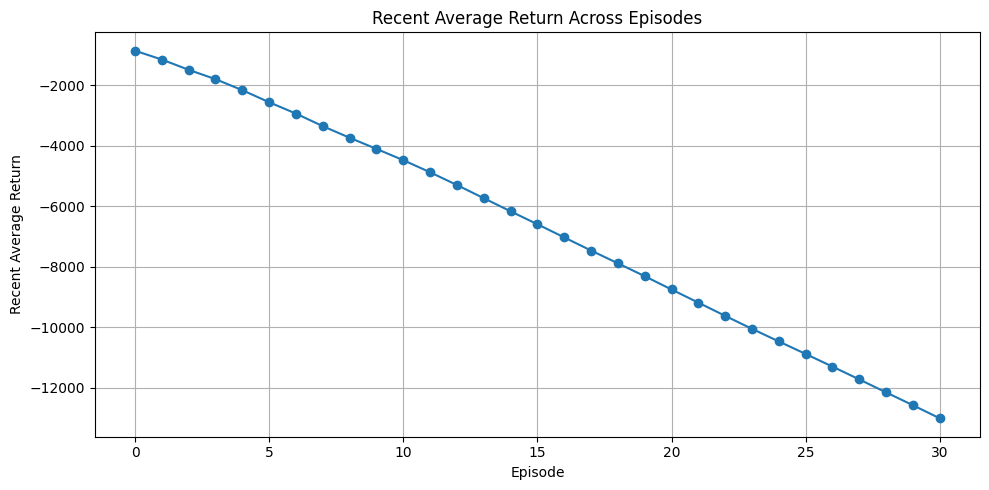

In [435]:

# df must contain: df["episode"], df["total_reward"]
df_sorted = df.sort_values("episode")

plt.figure(figsize=(10, 5))
plt.plot(df_sorted["episode"], df_sorted["recent_avg_return"], marker="o")
plt.xlabel("Episode")
plt.ylabel("Recent Average Return")
plt.title("Recent Average Return Across Episodes")
plt.grid(True)
plt.tight_layout()
plt.show()



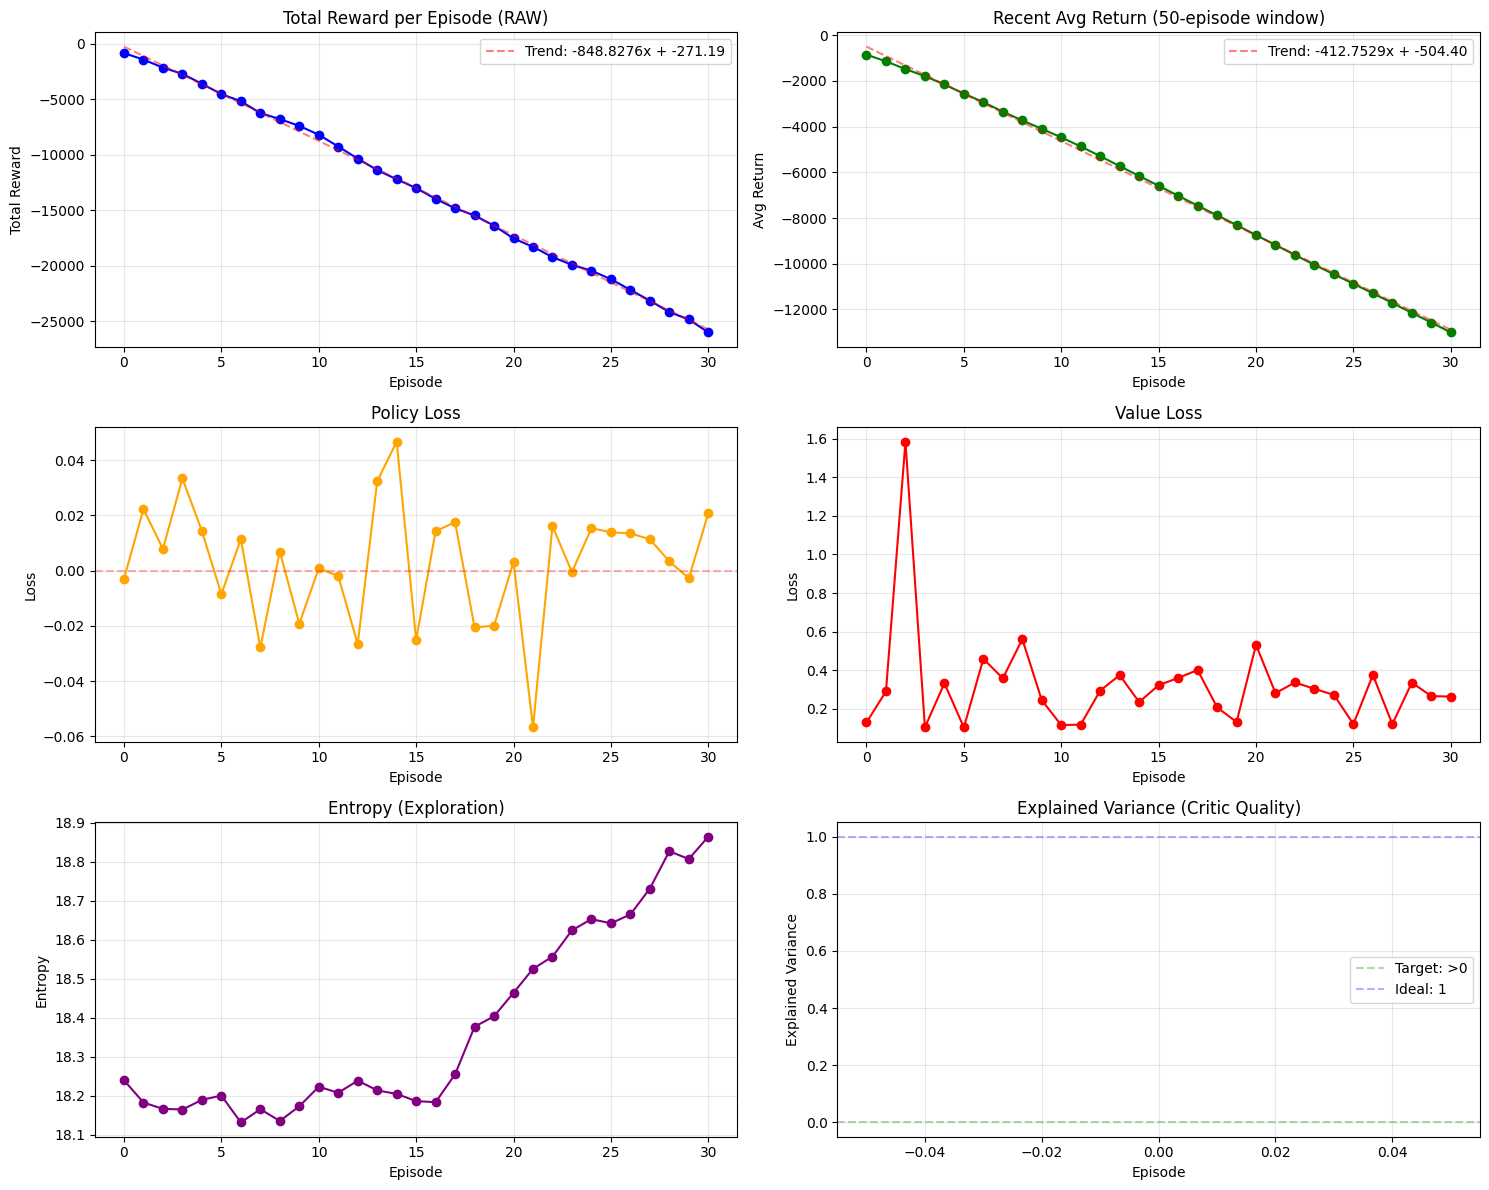


=== DIAGNOSTIC SUMMARY ===
Total Episodes: 31

Reward Trend: -848.827631 per episode
⚠️  SEVERE: Rewards are DECREASING significantly!

First Episode Reward: -855.75
Last Episode Reward: -26008.15
Best Episode Reward: -855.75
Worst Episode Reward: -26008.15

Explained Variance (last): None (not enough data)
⚠️  WARNING: Insufficient data to compute explained variance

Entropy (last): 18.8648
⚠️  Policy is still very random (high exploration)


In [436]:
# Comprehensive diagnostic plot
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
df_sorted = df.sort_values("episode").reset_index(drop=True)

# 1. Total Reward trend
axes[0, 0].plot(df_sorted["episode"], df_sorted["total_reward"], marker="o", color="blue")
axes[0, 0].set_title("Total Reward per Episode (RAW)")
axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Total Reward")
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_sorted["episode"], df_sorted["total_reward"], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_sorted["episode"], p(df_sorted["episode"]), "r--", alpha=0.5, label=f"Trend: {z[0]:.4f}x + {z[1]:.2f}")
axes[0, 0].legend()

# 2. Recent Average Return
axes[0, 1].plot(df_sorted["episode"], df_sorted["recent_avg_return"], marker="o", color="green")
axes[0, 1].set_title("Recent Avg Return (50-episode window)")
axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Avg Return")
axes[0, 1].grid(True, alpha=0.3)

z2 = np.polyfit(df_sorted["episode"], df_sorted["recent_avg_return"], 1)
p2 = np.poly1d(z2)
axes[0, 1].plot(df_sorted["episode"], p2(df_sorted["episode"]), "r--", alpha=0.5, label=f"Trend: {z2[0]:.4f}x + {z2[1]:.2f}")
axes[0, 1].legend()

# 3. Policy Loss
axes[1, 0].plot(df_sorted["episode"], df_sorted["policy_loss"], marker="o", color="orange")
axes[1, 0].set_title("Policy Loss")
axes[1, 0].set_xlabel("Episode")
axes[1, 0].set_ylabel("Loss")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# 4. Value Loss
axes[1, 1].plot(df_sorted["episode"], df_sorted["value_loss"], marker="o", color="red")
axes[1, 1].set_title("Value Loss")
axes[1, 1].set_xlabel("Episode")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].grid(True, alpha=0.3)

# 5. Entropy (should decrease over time)
axes[2, 0].plot(df_sorted["episode"], df_sorted["entropy"], marker="o", color="purple")
axes[2, 0].set_title("Entropy (Exploration)")
axes[2, 0].set_xlabel("Episode")
axes[2, 0].set_ylabel("Entropy")
axes[2, 0].grid(True, alpha=0.3)

# 6. Explained Variance (should increase toward 1)
axes[2, 1].plot(df_sorted["episode"], df_sorted["explained_variance"], marker="o", color="brown")
axes[2, 1].set_title("Explained Variance (Critic Quality)")
axes[2, 1].set_xlabel("Episode")
axes[2, 1].set_ylabel("Explained Variance")
axes[2, 1].axhline(y=0, color='g', linestyle='--', alpha=0.3, label="Target: >0")
axes[2, 1].axhline(y=1, color='b', linestyle='--', alpha=0.3, label="Ideal: 1")
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== DIAGNOSTIC SUMMARY ===")
print(f"Total Episodes: {len(df_sorted)}")
print(f"\nReward Trend: {z[0]:.6f} per episode")
if z[0] < -0.01:
    print("⚠️  SEVERE: Rewards are DECREASING significantly!")
elif z[0] < 0:
    print("⚠️  WARNING: Rewards are slowly decreasing")
else:
    print("✓ Rewards are increasing or stable")

print(f"\nFirst Episode Reward: {df_sorted['total_reward'].iloc[0]:.2f}")
print(f"Last Episode Reward: {df_sorted['total_reward'].iloc[-1]:.2f}")
print(f"Best Episode Reward: {df_sorted['total_reward'].max():.2f}")
print(f"Worst Episode Reward: {df_sorted['total_reward'].min():.2f}")

ev_last = df_sorted['explained_variance'].iloc[-1]
if ev_last is None:
    print("\nExplained Variance (last): None (not enough data)")
    print("⚠️  WARNING: Insufficient data to compute explained variance")
else:
    print(f"\nExplained Variance (last): {ev_last:.4f}")
    if ev_last < -10:
        print("⚠️  CRITICAL: Value network is completely broken!")
    elif ev_last < 0:
        print("⚠️  WARNING: Value network worse than baseline")
    else:
        print("✓ Value network is learning")

print(f"\nEntropy (last): {df_sorted['entropy'].iloc[-1]:.4f}")
if df_sorted['entropy'].iloc[-1] > 5:
    print("⚠️  Policy is still very random (high exploration)")
elif df_sorted['entropy'].iloc[-1] < 0.1:
    print("⚠️  Policy may be too deterministic")
else:
    print("✓ Entropy in reasonable range")

In [437]:
# Check for pathological behaviors
print("=== PATHOLOGY CHECK ===\n")

# 1. Check if advantages are collapsed
print("Advantage Statistics (last 10 episodes):")
last_10 = df_sorted.tail(10)
print(f"  Mean: {last_10['adv_mean'].mean():.8f}")
print(f"  Std: {last_10['adv_std'].mean():.8f}")
if last_10['adv_std'].mean() < 0.1:
    print("  ⚠️  PROBLEM: Advantages have very low std - policy not learning!\n")
else:
    print("  ✓ Advantages seem normal\n")

# 2. Check if policy is updating
print("Policy Update Statistics (last 10 episodes):")
print(f"  Approx KL: {last_10['approx_kl'].mean():.8f}")
print(f"  Mean Ratio: {last_10['mean_ratio'].mean():.6f}")
print(f"  Percent Clipped: {last_10['percent_clipped'].mean():.2f}%")
if last_10['approx_kl'].mean() < 1e-5:
    print("  ⚠️  PROBLEM: KL too small - policy frozen!\n")
elif last_10['approx_kl'].mean() > 0.1:
    print("  ⚠️  WARNING: KL too large - policy unstable!\n")
else:
    print("  ✓ Policy updating normally\n")

# 3. Check food action distribution
print("Food Action Distribution (last episode):")
last_food = last_10['food_counts'].iloc[-1]
total_actions = sum(last_food)
for i, action in enumerate(["REPRODUCE", "ACTIVATE_SPECIAL", "IDLE_FOOD"]):
    pct = (last_food[i] / total_actions * 100) if total_actions > 0 else 0
    print(f"  {action}: {last_food[i]} ({pct:.1f}%)")

if total_actions > 0:
    reproduce_pct = last_food[0] / total_actions
    if reproduce_pct > 0.9:
        print("  ⚠️  PROBLEM: Agent only reproducing - reward hacking!\n")
    elif reproduce_pct < 0.01:
        print("  ⚠️  WARNING: Agent never reproducing - missing important action\n")
    else:
        print("  ✓ Action distribution seems balanced\n")

# 4. Check for reward collapse
print("Reward Statistics:")
print(f"  Mean: {df_sorted['total_reward'].mean():.2f}")
print(f"  Std: {df_sorted['total_reward'].std():.2f}")
print(f"  Coefficient of Variation: {df_sorted['total_reward'].std() / abs(df_sorted['total_reward'].mean()):.2f}")

# Check if rewards are getting more uniform (collapse)
first_half_std = df_sorted['total_reward'].iloc[:len(df_sorted)//2].std()
second_half_std = df_sorted['total_reward'].iloc[len(df_sorted)//2:].std()
print(f"  First half std: {first_half_std:.2f}")
print(f"  Second half std: {second_half_std:.2f}")
if second_half_std < first_half_std * 0.5:
    print("  ⚠️  WARNING: Reward variance decreasing - policy converging to suboptimal behavior\n")
else:
    print("  ✓ Reward variance stable\n")

=== PATHOLOGY CHECK ===

Advantage Statistics (last 10 episodes):
  Mean: 0.00000003
  Std: 0.99999998
  ✓ Advantages seem normal

Policy Update Statistics (last 10 episodes):
  Approx KL: 0.03050980
  Mean Ratio: 0.997412
  Percent Clipped: 15.08%
  ✓ Policy updating normally

Food Action Distribution (last episode):
  REPRODUCE: 0 (0.0%)
  ACTIVATE_SPECIAL: 70166 (100.0%)
  IDLE_FOOD: 0 (0.0%)
  ⚠️  WARNING: Agent never reproducing - missing important action

Reward Statistics:
  Mean: -13003.60
  Std: 7721.53
  Coefficient of Variation: 0.59
  First half std: 3641.07
  Second half std: 4021.24
  ✓ Reward variance stable



In [438]:
# RECOMMENDED FIXES based on your specific metrics

print("=== RECOMMENDED ACTIONS ===\n")

last_ep = df_sorted.iloc[-1]

# Check 1: Explained Variance
ev = last_ep['explained_variance']
print(f"1. Explained Variance Check: {ev:.4f}")
if ev < -100:
    print("   ❌ CRITICAL ISSUE: Value network is catastrophically broken!")
    print("   → IMMEDIATE ACTION: Restart training with higher critic LR (5e-3)")
    print("   → Consider: Reset critic weights, use simpler critic architecture")
    print("   → Consider: Check if rewards are in reasonable range\n")
elif ev < -10:
    print("   ⚠️  SEVERE: Value network predictions are very bad")
    print("   → ACTION: Increase VALUE_LOSS_COEF to 2.0")
    print("   → ACTION: Increase CRITIC_LEARNING_RATE to 5e-3")
    print("   → ACTION: Consider using reward clipping in [-10, 10]\n")
elif ev < 0:
    print("   ⚠️  WARNING: Value network worse than baseline")
    print("   → Monitor: Should improve in next 50 episodes")
    print("   → If not: Increase critic learning rate\n")
else:
    print("   ✓ Value network is learning (but may still be suboptimal)\n")

# Check 2: Advantage Stats
adv_std = last_ep['adv_std']
print(f"2. Advantage Std Check: {adv_std:.6f}")
if abs(adv_std - 1.0) < 0.01:
    print("   ⚠️  WARNING: Advantages normalized to exactly std=1")
    print("   → This might mean advantages are just noise from bad value estimates")
    print("   → Fix the value network first (see above)\n")
else:
    print("   ✓ Advantage normalization seems to be working\n")

# Check 3: KL Divergence
kl = last_ep['approx_kl']
print(f"3. KL Divergence Check: {kl:.8f}")
if kl < 1e-6:
    print("   ❌ CRITICAL: Policy is frozen (not updating at all)")
    print("   → ACTION: Increase LEARNING_RATE to 3e-3")
    print("   → ACTION: Check if gradients are vanishing")
    print("   → ACTION: Reduce MAX_GRAD_NORM to allow larger updates\n")
elif kl < 1e-4:
    print("   ⚠️  WARNING: Policy updates are very small")
    print("   → Consider: Increasing learning rate")
    print("   → Consider: Check if advantages have meaningful signal\n")
elif kl > 0.05:
    print("   ⚠️  WARNING: Policy changes too much per update")
    print("   → ACTION: Reduce LEARNING_RATE")
    print("   → ACTION: Reduce PPO_EPOCHS\n")
else:
    print("   ✓ Policy updating at reasonable rate\n")

# Check 4: Reward Trend
reward_slope = np.polyfit(df_sorted["episode"], df_sorted["total_reward"], 1)[0]
print(f"4. Reward Trend Check: {reward_slope:.4f} per episode")
if reward_slope < -1.0:
    print("   ❌ CRITICAL: Rewards rapidly decreasing!")
    print("   → LIKELY CAUSE: Value network broken + reward normalization")
    print("   → ACTION: Restart training with fixes applied")
    print("   → ACTION: Monitor reward_running_mean/std in logs\n")
elif reward_slope < 0:
    print("   ⚠️  WARNING: Rewards slowly decreasing")
    print("   → Possible causes: Policy converging to suboptimal, or value net issues")
    print("   → ACTION: Check action distributions for reward hacking")
    print("   → ACTION: Increase exploration (entropy coef)\n")
else:
    print("   ✓ Rewards stable or increasing\n")

# Check 5: Entropy
entropy = last_ep['entropy']
print(f"5. Entropy Check: {entropy:.4f}")
if entropy > 8:
    print("   ⚠️  WARNING: Very high entropy - policy still very random")
    print("   → Normal in early training")
    print("   → If persists: Policy not learning (check gradients)\n")
elif entropy < 0.5:
    print("   ⚠️  WARNING: Very low entropy - policy too deterministic")
    print("   → Risk of getting stuck in local optimum")
    print("   → ACTION: Increase ENTROPY_COEF to 0.01\n")
else:
    print("   ✓ Entropy in reasonable range\n")

print("\n" + "="*60)
print("SUMMARY RECOMMENDATION:")
print("="*60)

if ev < -50 or kl < 1e-6:
    print("🔴 RESTART TRAINING with updated hyperparameters")
    print("   The current training has fundamental issues that won't self-correct.")
elif reward_slope < -0.5:
    print("🟡 CONTINUE but MONITOR CLOSELY")
    print("   Apply the recommended fixes and check next 20 episodes.")
else:
    print("🟢 CONTINUE TRAINING")
    print("   Training appears mostly healthy. Minor adjustments may help.")

=== RECOMMENDED ACTIONS ===



TypeError: unsupported format string passed to NoneType.__format__

## 🚨 CRITICAL DEBUGGING - Find Root Cause

The policy is **STILL frozen** (KL = 1e-8). This means the previous fixes didn't work. Let's diagnose the actual problem:

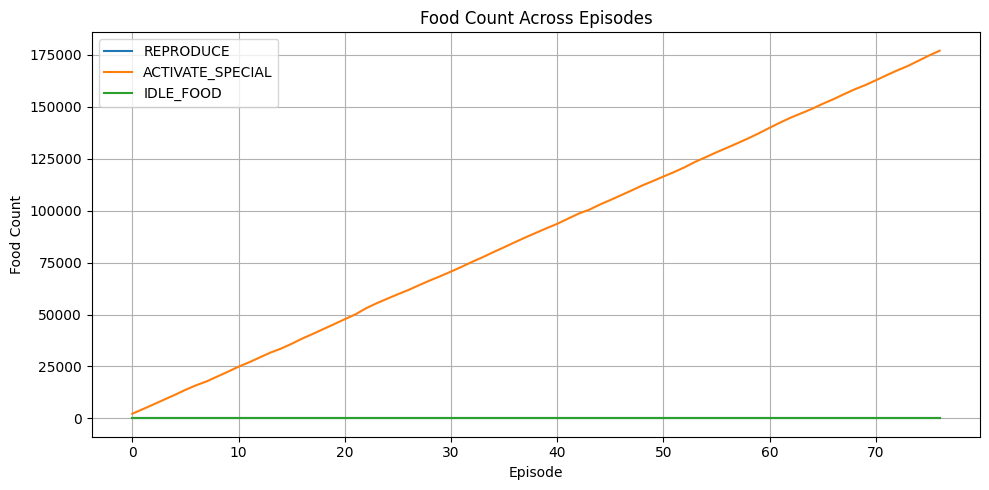

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_sorted = df.sort_values("episode").reset_index(drop=True)

# Expand the list column into three numeric columns
food_cols = df_sorted["food_counts"].apply(pd.Series)
food_cols.columns = ["REPRODUCE", "ACTIVATE_SPECIAL", "IDLE_FOOD"]

plt.figure(figsize=(10, 5))
plt.plot(df_sorted["episode"], food_cols["REPRODUCE"], label="REPRODUCE")
plt.plot(df_sorted["episode"], food_cols["ACTIVATE_SPECIAL"], label="ACTIVATE_SPECIAL")
plt.plot(df_sorted["episode"], food_cols["IDLE_FOOD"], label="IDLE_FOOD")

plt.xlabel("Episode")
plt.ylabel("Food Count")
plt.title("Food Count Across Episodes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


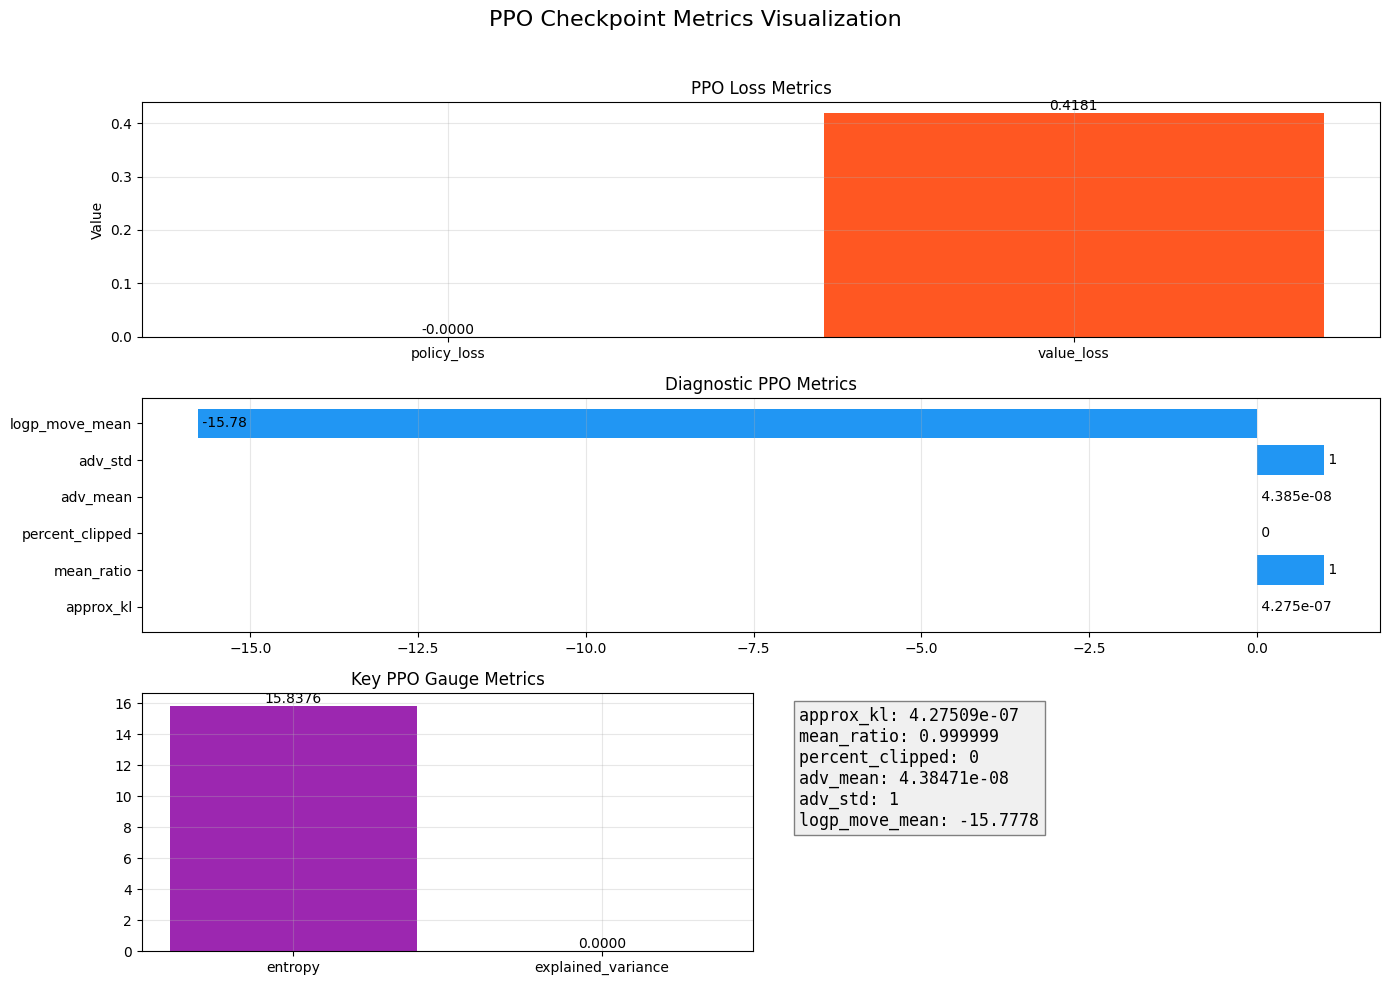

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# df already loaded; extract the first (or chosen) checkpoint row
row = df.iloc[0]

# Separate metrics logically
loss_metrics = {
    "policy_loss": row["policy_loss"],
    "value_loss": row["value_loss"],
}

diagnostic_metrics = {
    "approx_kl": row["approx_kl"],
    "mean_ratio": row["mean_ratio"],
    "percent_clipped": row["percent_clipped"],
    "adv_mean": row["adv_mean"],
    "adv_std": row["adv_std"],
    "logp_move_mean": row["logp_move_mean"]
}

gauge_metrics = {
    "entropy": row["entropy"],
    "explained_variance": row["explained_variance"]
}

# ---- FIGURE LAYOUT ----
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.1])

# -------------------------------------------------------------------
# 1. BAR CHART — Loss-related metrics
# -------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])
ax1.bar(loss_metrics.keys(), loss_metrics.values(), color=["#4CAF50", "#FF5722"])
ax1.set_title("PPO Loss Metrics")
ax1.set_ylabel("Value")
ax1.grid(True, alpha=0.3)

# Annotate values
for i, v in enumerate(loss_metrics.values()):
    ax1.text(i, v, f"{v:.4f}", ha="center", va="bottom")

# -------------------------------------------------------------------
# 2. HORIZONTAL BAR — Diagnostic metrics
# -------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1, :])
keys = list(diagnostic_metrics.keys())
vals = list(diagnostic_metrics.values())

ax2.barh(keys, vals, color="#2196F3")
ax2.set_title("Diagnostic PPO Metrics")
ax2.grid(True, axis="x", alpha=0.3)

for i, v in enumerate(vals):
    ax2.text(v, i, f" {v:.4g}", va="center")

# -------------------------------------------------------------------
# 3. GAUGE METRICS — Entropy + Explained variance
# -------------------------------------------------------------------
ax3 = fig.add_subplot(gs[2, 0])
bar_names = list(gauge_metrics.keys())
bar_vals = list(gauge_metrics.values())

ax3.bar(bar_names, bar_vals, color=["#9C27B0", "#FFC107"])
ax3.set_title("Key PPO Gauge Metrics")
ax3.grid(True, alpha=0.3)

for i, v in enumerate(bar_vals):
    ax3.text(i, v, f"{v:.4f}", ha="center", va="bottom")

# -------------------------------------------------------------------
# 4. SMALL NUMBERS BOX — KL, tiny values, etc.
# -------------------------------------------------------------------
ax4 = fig.add_subplot(gs[2, 1])
ax4.axis("off")
text = "\n".join([
    f"{k}: {v:.6g}" for k, v in diagnostic_metrics.items()
])
ax4.text(0.05, 0.95, text, va="top", fontsize=12,
         family="monospace", bbox=dict(facecolor="#f0f0f0", edgecolor="gray"))

# -------------------------------------------------------------------
# Layout
plt.suptitle("PPO Checkpoint Metrics Visualization", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


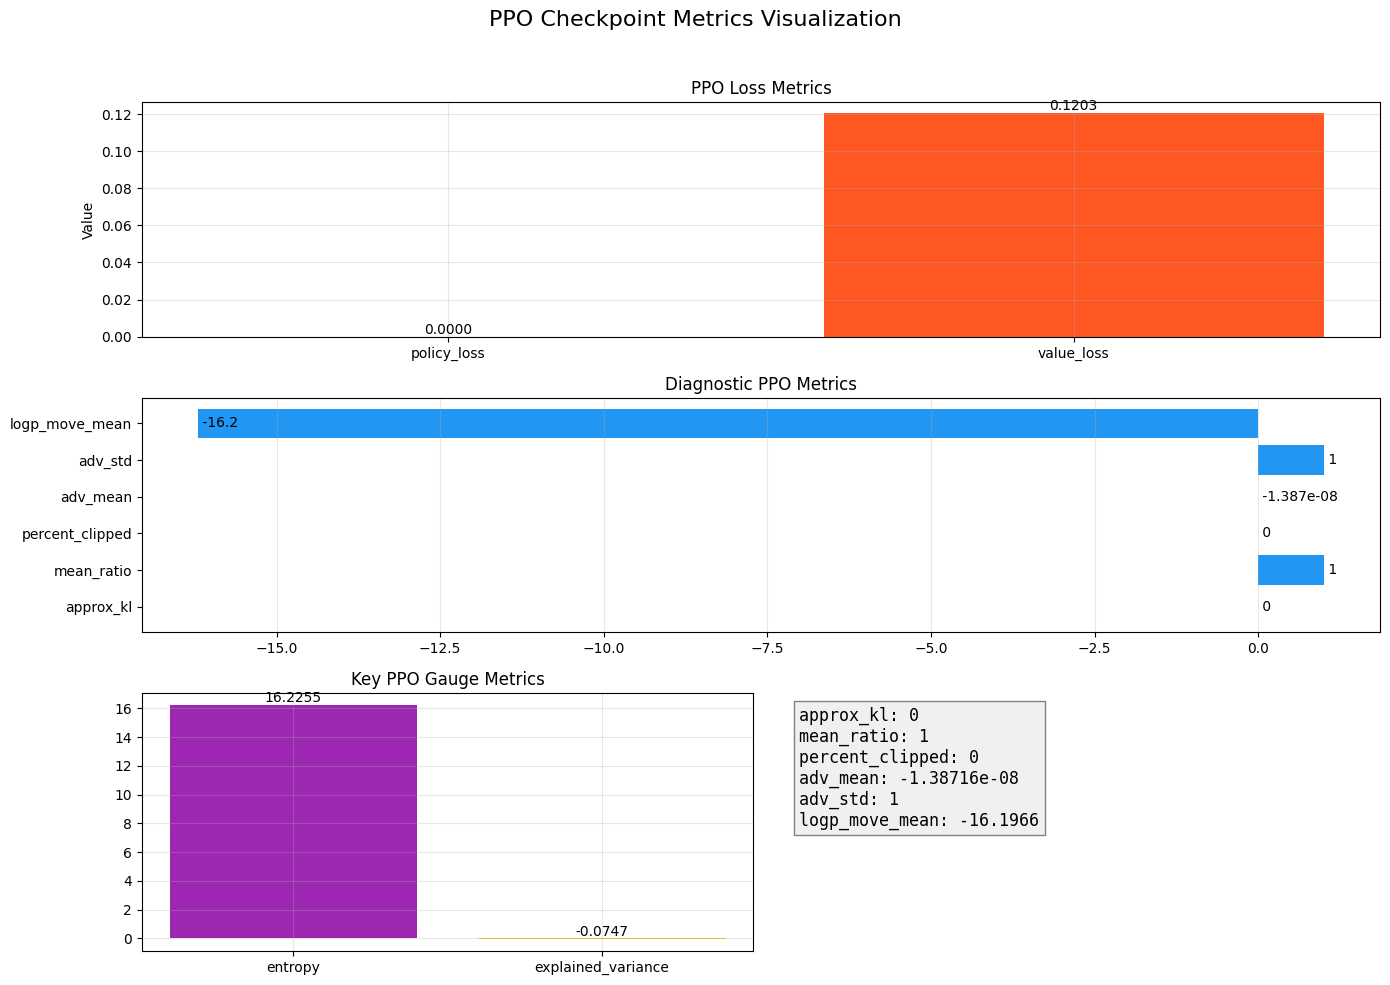

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# df already loaded; extract the first (or chosen) checkpoint row
row = df.iloc[-1]

# Separate metrics logically
loss_metrics = {
    "policy_loss": row["policy_loss"],
    "value_loss": row["value_loss"],
}

diagnostic_metrics = {
    "approx_kl": row["approx_kl"],
    "mean_ratio": row["mean_ratio"],
    "percent_clipped": row["percent_clipped"],
    "adv_mean": row["adv_mean"],
    "adv_std": row["adv_std"],
    "logp_move_mean": row["logp_move_mean"]
}

gauge_metrics = {
    "entropy": row["entropy"],
    "explained_variance": row["explained_variance"]
}

# ---- FIGURE LAYOUT ----
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.1])

# -------------------------------------------------------------------
# 1. BAR CHART — Loss-related metrics
# -------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])
ax1.bar(loss_metrics.keys(), loss_metrics.values(), color=["#4CAF50", "#FF5722"])
ax1.set_title("PPO Loss Metrics")
ax1.set_ylabel("Value")
ax1.grid(True, alpha=0.3)

# Annotate values
for i, v in enumerate(loss_metrics.values()):
    ax1.text(i, v, f"{v:.4f}", ha="center", va="bottom")

# -------------------------------------------------------------------
# 2. HORIZONTAL BAR — Diagnostic metrics
# -------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1, :])
keys = list(diagnostic_metrics.keys())
vals = list(diagnostic_metrics.values())

ax2.barh(keys, vals, color="#2196F3")
ax2.set_title("Diagnostic PPO Metrics")
ax2.grid(True, axis="x", alpha=0.3)

for i, v in enumerate(vals):
    ax2.text(v, i, f" {v:.4g}", va="center")

# -------------------------------------------------------------------
# 3. GAUGE METRICS — Entropy + Explained variance
# -------------------------------------------------------------------
ax3 = fig.add_subplot(gs[2, 0])
bar_names = list(gauge_metrics.keys())
bar_vals = list(gauge_metrics.values())

ax3.bar(bar_names, bar_vals, color=["#9C27B0", "#FFC107"])
ax3.set_title("Key PPO Gauge Metrics")
ax3.grid(True, alpha=0.3)

for i, v in enumerate(bar_vals):
    ax3.text(i, v, f"{v:.4f}", ha="center", va="bottom")

# -------------------------------------------------------------------
# 4. SMALL NUMBERS BOX — KL, tiny values, etc.
# -------------------------------------------------------------------
ax4 = fig.add_subplot(gs[2, 1])
ax4.axis("off")
text = "\n".join([
    f"{k}: {v:.6g}" for k, v in diagnostic_metrics.items()
])
ax4.text(0.05, 0.95, text, va="top", fontsize=12,
         family="monospace", bbox=dict(facecolor="#f0f0f0", edgecolor="gray"))

# -------------------------------------------------------------------
# Layout
plt.suptitle("PPO Checkpoint Metrics Visualization", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
